In [58]:
import re
import random
import pandas as pd
import hashlib

In [59]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [60]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Lost in a Good Book, Fforde",38.236109,7.647222,11.367641,5
Power BI,261.626229,7.928068,22.145519,33
Pandas,346.350152,38.483350,90.609562,9
Azure AD Authentication,427.435482,85.487096,177.337149,5
Azure Private DNS,522.279766,87.046628,243.808283,6
DAX,677.289747,75.254416,262.047040,9
Azure DevOps Pipelines,729.262018,72.926202,160.216101,10
CCH Axcess,769.629288,26.538941,67.451338,29
Azure Functions + PP365,952.163283,68.011663,119.022453,14
Terraform,1055.251729,87.937644,325.716926,12


# Histogram

sum of ages: ~40953.92


<Axes: >

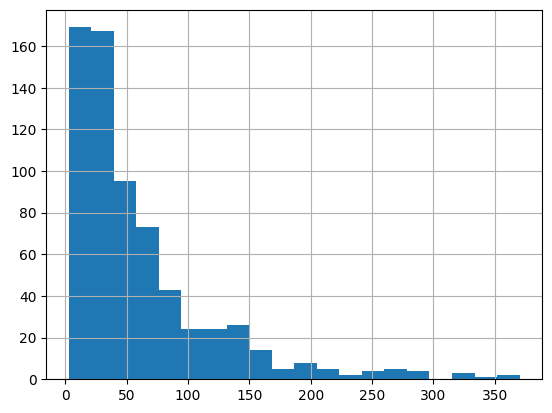

In [61]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~40953.92


<Axes: >

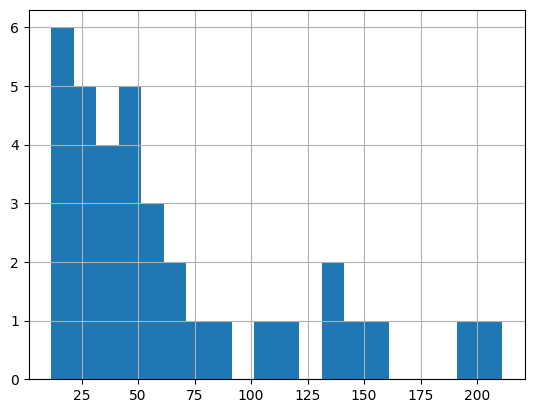

In [62]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [63]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [64]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [65]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [66]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [67]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [68]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [69]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [70]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [71]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [72]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [73]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 674
Total card age: 40953.92


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
153,Azure AD Authentication,"Role Assignment\nLinks a principal (user, grou...",f445b4bb29b65e4bfdc8ae15101622af,177.337149,85.487096,-177.337149,427.435482,0.477679,5,5,0,0,-177.337149
383,Azure AD Authentication,Service Principal Authentication Methods\nAuth...,551e14e36b831568933c1ffb27e349ba,79.002230,85.487096,-177.337149,427.435482,0.477679,5,5,1,0,-79.002230
608,Azure AD Authentication,Managed Identities\nAzure-managed identities u...,2ad76e64637c614682a8f5211278b094,70.425343,85.487096,-177.337149,427.435482,0.477679,5,5,2,0,-70.425343
154,Azure AD Authentication,Azure AD Roles vs Azure Resource Roles\nAzure ...,6c6c1200236d748fc352faaaf8856bff,59.440676,85.487096,-177.337149,427.435482,0.477679,5,5,3,0,-59.440676
384,Azure AD Authentication,Service Principal\nA security identity for an ...,a28d9e0df996c0ac0eb889d97e57ec4f,41.230084,85.487096,-177.337149,427.435482,0.477679,5,5,4,0,-41.230084
223,"Lost in a Good Book, Fforde",Wisteria: A climbing flowering plant with frag...,41f99c38886a575deffe4cdb28b87571,11.367641,7.647222,-11.367641,38.236109,0.580311,5,5,0,0,-11.367641
451,"Lost in a Good Book, Fforde",Impresario: A manager or producer of theatrica...,4f8698634f04d91b6d1e02965ab303c3,8.597650,7.647222,-11.367641,38.236109,0.580311,5,5,1,0,-8.597650
452,"Lost in a Good Book, Fforde",Pelmet(s): A decorative framework or fabric co...,386057c112fcabc4396967380e869e17,7.979232,7.647222,-11.367641,38.236109,0.580311,5,5,2,0,-7.979232
224,"Lost in a Good Book, Fforde",Phaeton (bodied automobile): A type of early o...,533ef12bba9de6edfacbc4bd652dc77d,5.669167,7.647222,-11.367641,38.236109,0.580311,5,5,3,0,-5.669167
673,"Lost in a Good Book, Fforde","Perfidious: Deceitful and untrustworthy, often...",7d5d01dee92ff34b559c47bcf04e5576,4.622419,7.647222,-11.367641,38.236109,0.580311,5,5,4,0,-4.622419



## Random

In [74]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [75]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,frequency,count,n_fold,neg_age
6,FSLogix,Q: How does FSLogix improve Office 365 perform...,f35dc0360cf624fcdfa25708f25b7398,370.270469,84.676113,-370.270469,2624.959518,0.865500,31,31,0,0,-370.270469
17,Azure Compute Gallery,SAS Token (Shared Access Signature) – A tempor...,16543cefaf9d760fb4860bf0a6fcb4bb,360.413195,70.060271,-360.413195,2311.988948,0.751253,33,33,0,0,-360.413195
28,Asynchronous Python,Coroutine Object\nThe result of calling an asy...,877cc6e7d0264598007bf336b88f4c3e,335.076784,77.655693,-335.076784,2562.637853,0.965767,33,33,0,0,-335.076784
39,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,325.716926,87.937644,-325.716926,1055.251729,0.225386,12,12,0,0,-325.716926
43,PowerShell Modules,PSReadLine Module\n\nDefinition: A module that...,b41f499c95e1fc0bd9767a6315e4b432,320.688140,93.140436,-320.688140,2514.791772,0.130196,27,27,0,0,-320.688140
240,FSLogix,Redirector Driver:\nA mechanism within FSLogix...,f51a72bfb75cf817d822f0fb50b94a12,317.931680,84.676113,-370.270469,2624.959518,0.865500,31,31,1,0,-317.931680
52,JavaScript Concepts,Using Object.keys() with for...of Loop: The Ob...,06c15a040f743007e381b243ccc3d915,295.495520,59.980904,-295.495520,4018.720584,0.863374,67,67,0,0,-295.495520
75,C# Basics,What are common libraries and frameworks in C#...,d714cbc1740b344f84ed84278b332f36,292.565746,72.287250,-292.565746,1734.894003,0.429758,24,24,0,0,-292.565746
467,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,288.708366,84.676113,-370.270469,2624.959518,0.865500,31,31,2,0,-288.708366
83,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,281.836903,58.883048,-281.836903,3120.801526,0.846426,53,53,0,0,-281.836903


In [76]:
existing_cards['age'].mean()

60.762489837399215